# Similarity Search using FAISS

**About similarity search**

Traditional databases are made up of structured tables containing symbolic information. For example, an image collection would be represented as a table with one row per indexed photo. Each row contains information such as an image identifier and descriptive text. Rows can be linked to entries from other tables as well, such as an image with people in it being linked to a table of names.

AI tools, like text embedding (word2vec) or convolutional neural net (CNN) descriptors trained with deep learning, generate high-dimensional vectors. These representations are much more powerful and flexible than a fixed symbolic representation, as we’ll explain in this post. Yet traditional databases that can be queried with SQL are not adapted to these new representations. First, the huge inflow of new multimedia items creates billions of vectors. Second, and more importantly, finding similar entries means finding similar high-dimensional vectors, which is inefficient if not impossible with standard query languages.

**How can a vector representation be used?**

Let’s say you have an image of a building — for example, the city hall of some midsize city whose name you forgot — and you’d like to find all other images of this building in the image collection. A key/value query that is typically used in SQL doesn’t help, because you’ve forgotten the name of the city.

This is where similarity search kicks in. The vector representation for images is designed to produce similar vectors for similar images, where similar vectors are defined as those that are nearby in Euclidean space.

Another application for vector representation is classification. Imagine you need a classifier that determines which images in a collection represent a daisy. Training the classifier is a well-known process: The algorithm takes as input images of daisies and images of non-daisies (cars, sheep, roses, cornflowers). If the classifier is linear, it outputs a classification vector whose property is that its dot product with the image vector reflects how likely it is that the image contains a daisy. Then the dot product can be computed with all entries in the collection and the images with the highest values are returned. This type of query is a “maximum inner-product” search.

So, for similarity search and classification, we need the following operations:

Given a query vector, return the list of database objects that are nearest to this vector in terms of Euclidean distance.
Given a query vector, return the list of database objects that have the highest dot product with this vector.
An added challenge is that we want to do these operations on a large scale, on billions of vectors.

**Software packages**
The software tools currently available aren’t sufficient for the database search operations described above. Traditional SQL database systems are impractical because they’re optimized for hash-based searches or 1D interval searches. The similarity search functions that are available in packages like OpenCV are severely limited in terms of scalability, as are other similarity search libraries considering “small” data sets (for example, only 1 million vectors). Other packages are research artifacts produced for a published paper to demonstrate performance in specific settings.



With Faiss, the library that addresses the limitations mentioned above. Among its advantages:

1. Faiss provides several similarity search methods that span a wide spectrum of usage trade-offs.
2. Faiss is optimized for memory usage and speed.
3. Faiss offers a state-of-the-art GPU implementation for the most relevant indexing methods.

**It is preferable for the faiss to run on Google Colab**

In [2]:
pip install faiss-cpu

     |████████████████████████████████| 8.2MB 6.2MB/s 


In [3]:
import numpy as np 
import faiss  # this will import the faiss library

In [4]:
import pandas as pd

In [5]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [7]:
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(180, 180, 3))
def extract_features(img_path, model):
    input_shape = (180, 180, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [8]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [9]:
root_dir = './'
filenames = sorted(get_file_list(root_dir))

In [10]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


**Here all the images are converted into vectors**

In [11]:
len(filenames)

454

In [12]:
feature_list

[array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00960332], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01151063], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00245615], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00084782], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01391424], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00622939], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00999784], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00802735], dtype=float32),
 array([0.  

In [13]:
feature_list=np.array(feature_list)

In [14]:
type(feature_list)

numpy.ndarray

In [15]:
feature_list.shape

(454, 73728)

In [16]:
dimension = 73728    # dimensions of each vector                         
n = len(filenames)    # number of vectors                   
np.random.seed(1)             
db_vectors = feature_list 

In [17]:
db_vectors.shape

(454, 73728)

In [18]:
nlist = 1  # number of clusters
quantiser = faiss.IndexFlatL2(dimension)  
index = faiss.IndexIVFFlat(quantiser, dimension, nlist,   faiss.METRIC_L2)

In [19]:
print(index.is_trained)   # False
index.train(db_vectors)  # train on the database vectors
print(index.ntotal)   # 0
index.add(db_vectors)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)   # 200

False
0
True
454


In [20]:
# nprobe = 1  # find 2 most similar clusters
# n_query = 1  
# k = 10  # return 3 nearest neighbours
# np.random.seed(0)   
# query_vectors = features#np.random.random((n_query, dimension)).astype('float32')
# distances, indices = index.search(query_vectors, k)

In [21]:
# feature=features.reshape(1,73728)
# features.shape

In [22]:
nprobe = 1  # find 2 most similar clusters
n_query = 20  
k = 10  # return 3 nearest neighbours
np.random.seed(0)   
query_vectors = feature_list#np.random.random((n_query, dimension)).astype('float32')
distances, indices = index.search(query_vectors, k)

In [24]:
distances

array([[0.        , 1.1244752 , 1.139825  , ..., 1.1946715 , 1.2217207 ,
        1.2238195 ],
       [0.        , 1.3594319 , 1.4043307 , ..., 1.4490455 , 1.4510218 ,
        1.464354  ],
       [0.        , 0.97222126, 1.0250579 , ..., 1.1741995 , 1.1909689 ,
        1.2021248 ],
       ...,
       [0.        , 1.1111798 , 1.1708739 , ..., 1.3032188 , 1.3064568 ,
        1.3140421 ],
       [0.        , 1.0305172 , 1.2906545 , ..., 1.324662  , 1.3289143 ,
        1.3312322 ],
       [0.        , 1.3685032 , 1.385512  , ..., 1.4533623 , 1.4547973 ,
        1.4619927 ]], dtype=float32)

In [25]:
len(distances)

454

In [26]:
indices

array([[  0, 139,  92, ..., 209,  42,  22],
       [  1, 143, 146, ..., 438, 428, 277],
       [  2,  81, 236, ..., 137, 227,  52],
       ...,
       [451,  63,  61, ..., 134,   2, 138],
       [452,  85, 382, ...,  89, 164,  58],
       [453, 399, 327, ...,  35, 245, 442]])

In [27]:
faiss.write_index(index,"vector.index")  # save the index to 
# diskindex = faiss.read_index("vector.index")  # load the index 

In [28]:
diskindex = faiss.read_index("vector.index")

In [29]:
type(feature_list)

numpy.ndarray

In [30]:
feature_list.shape

(454, 73728)

In [31]:
#All the features are then stored into the pickle files. The pickle files are then loaded

SyntaxError: ignored

In [32]:
pickle.dump(feature_list, open('features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('filenames-caltech101.pickle','wb'))

In [33]:
filenames = pickle.load(open('filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('features-caltech101-resnet.pickle', 'rb'))

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [35]:
indices

array([[  0, 139,  92, ..., 209,  42,  22],
       [  1, 143, 146, ..., 438, 428, 277],
       [  2,  81, 236, ..., 137, 227,  52],
       ...,
       [451,  63,  61, ..., 134,   2, 138],
       [452,  85, 382, ...,  89, 164,  58],
       [453, 399, 327, ...,  35, 245, 442]])

In [36]:
filenames[1]

'./106.jpg'

In [37]:
filenames

['./102.jpg',
 './106.jpg',
 './107.jpg',
 './109.jpg',
 './111.jpg',
 './119.jpg',
 './12.jpg',
 './121.jpg',
 './122.jpg',
 './124.jpg',
 './127.jpg',
 './132.jpg',
 './140.jpg',
 './142.jpg',
 './146.jpg',
 './159.jpg',
 './162.jpg',
 './164.jpg',
 './167.jpg',
 './169.jpg',
 './171.jpg',
 './172.jpg',
 './175.jpg',
 './177.jpg',
 './178.jpg',
 './183.jpg',
 './19.jpg',
 './199.jpg',
 './205.jpg',
 './206.jpg',
 './215.jpg',
 './221.jpg',
 './223.jpg',
 './228.jpg',
 './23.jpg',
 './232.jpg',
 './234.jpg',
 './236.jpg',
 './24.jpg',
 './254.jpg',
 './256.jpg',
 './260.jpg',
 './266.jpg',
 './269.jpg',
 './272.jpg',
 './276.jpg',
 './281.jpg',
 './284.jpg',
 './286.jpg',
 './289.jpg',
 './290.jpg',
 './292.jpg',
 './301.jpg',
 './302.jpg',
 './307.jpg',
 './311.jpg',
 './313.jpg',
 './314.jpg',
 './316.jpg',
 './322.jpg',
 './331.jpg',
 './332.jpg',
 './335.jpg',
 './336.jpg',
 './342.jpg',
 './349.jpg',
 './358.jpg',
 './359.jpg',
 './362.jpg',
 './369.jpg',
 './391.jpg',
 './392.jp

In [38]:
filenaam = [i.split('/')[1] for i in filenames]

In [39]:
filenaam

['102.jpg',
 '106.jpg',
 '107.jpg',
 '109.jpg',
 '111.jpg',
 '119.jpg',
 '12.jpg',
 '121.jpg',
 '122.jpg',
 '124.jpg',
 '127.jpg',
 '132.jpg',
 '140.jpg',
 '142.jpg',
 '146.jpg',
 '159.jpg',
 '162.jpg',
 '164.jpg',
 '167.jpg',
 '169.jpg',
 '171.jpg',
 '172.jpg',
 '175.jpg',
 '177.jpg',
 '178.jpg',
 '183.jpg',
 '19.jpg',
 '199.jpg',
 '205.jpg',
 '206.jpg',
 '215.jpg',
 '221.jpg',
 '223.jpg',
 '228.jpg',
 '23.jpg',
 '232.jpg',
 '234.jpg',
 '236.jpg',
 '24.jpg',
 '254.jpg',
 '256.jpg',
 '260.jpg',
 '266.jpg',
 '269.jpg',
 '272.jpg',
 '276.jpg',
 '281.jpg',
 '284.jpg',
 '286.jpg',
 '289.jpg',
 '290.jpg',
 '292.jpg',
 '301.jpg',
 '302.jpg',
 '307.jpg',
 '311.jpg',
 '313.jpg',
 '314.jpg',
 '316.jpg',
 '322.jpg',
 '331.jpg',
 '332.jpg',
 '335.jpg',
 '336.jpg',
 '342.jpg',
 '349.jpg',
 '358.jpg',
 '359.jpg',
 '362.jpg',
 '369.jpg',
 '391.jpg',
 '392.jpg',
 '395.jpg',
 '397.jpg',
 '405.jpg',
 '408.jpg',
 '41.jpg',
 '416.jpg',
 '419.jpg',
 '42.jpg',
 '420.jpg',
 '421.jpg',
 '431.jpg',
 '437.jpg'

In [40]:
index = []
for i in range(len(filenaam)):
  index.append(i)

In [41]:
index

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [42]:
df = pd.DataFrame()
# df['index'] = index
df['images'] = filenaam

In [43]:
df

,images
0,102.jpg
1,106.jpg
2,107.jpg
3,109.jpg
4,111.jpg
...,...
449,95.jpg
450,96.jpg
451,97.jpg
452,98.jpg


In [44]:
indices_df = pd.DataFrame(indices)
indices_df

,0,1,2,3,4,5,6,7,8,9
0,0,139,92,431,338,183,405,209,42,22
1,1,143,146,272,376,411,278,438,428,277
2,2,81,236,134,193,138,54,137,227,52
3,3,329,251,76,44,348,450,240,264,269
4,4,126,248,45,275,162,389,36,407,132
...,...,...,...,...,...,...,...,...,...,...
449,449,110,92,135,54,253,81,292,236,333
450,450,77,285,139,141,248,22,374,142,213
451,451,63,61,70,81,360,292,134,2,138
452,452,85,382,294,357,153,434,89,164,58


In [45]:
# # for i in indices_df.items:
#   if i = df['']

In [46]:
df

,images
0,102.jpg
1,106.jpg
2,107.jpg
3,109.jpg
4,111.jpg
...,...
449,95.jpg
450,96.jpg
451,97.jpg
452,98.jpg


In [47]:
df1 = df.to_dict()
df1 = df1['images']

In [48]:
df1

{0: '102.jpg',
 1: '106.jpg',
 2: '107.jpg',
 3: '109.jpg',
 4: '111.jpg',
 5: '119.jpg',
 6: '12.jpg',
 7: '121.jpg',
 8: '122.jpg',
 9: '124.jpg',
 10: '127.jpg',
 11: '132.jpg',
 12: '140.jpg',
 13: '142.jpg',
 14: '146.jpg',
 15: '159.jpg',
 16: '162.jpg',
 17: '164.jpg',
 18: '167.jpg',
 19: '169.jpg',
 20: '171.jpg',
 21: '172.jpg',
 22: '175.jpg',
 23: '177.jpg',
 24: '178.jpg',
 25: '183.jpg',
 26: '19.jpg',
 27: '199.jpg',
 28: '205.jpg',
 29: '206.jpg',
 30: '215.jpg',
 31: '221.jpg',
 32: '223.jpg',
 33: '228.jpg',
 34: '23.jpg',
 35: '232.jpg',
 36: '234.jpg',
 37: '236.jpg',
 38: '24.jpg',
 39: '254.jpg',
 40: '256.jpg',
 41: '260.jpg',
 42: '266.jpg',
 43: '269.jpg',
 44: '272.jpg',
 45: '276.jpg',
 46: '281.jpg',
 47: '284.jpg',
 48: '286.jpg',
 49: '289.jpg',
 50: '290.jpg',
 51: '292.jpg',
 52: '301.jpg',
 53: '302.jpg',
 54: '307.jpg',
 55: '311.jpg',
 56: '313.jpg',
 57: '314.jpg',
 58: '316.jpg',
 59: '322.jpg',
 60: '331.jpg',
 61: '332.jpg',
 62: '335.jpg',
 63: '

In [49]:
indices_df

,0,1,2,3,4,5,6,7,8,9
0,0,139,92,431,338,183,405,209,42,22
1,1,143,146,272,376,411,278,438,428,277
2,2,81,236,134,193,138,54,137,227,52
3,3,329,251,76,44,348,450,240,264,269
4,4,126,248,45,275,162,389,36,407,132
...,...,...,...,...,...,...,...,...,...,...
449,449,110,92,135,54,253,81,292,236,333
450,450,77,285,139,141,248,22,374,142,213
451,451,63,61,70,81,360,292,134,2,138
452,452,85,382,294,357,153,434,89,164,58


In [50]:
indices_df = indices_df.replace(df1)
indices_df

,0,1,2,3,4,5,6,7,8,9
0,102.jpg,521.jpg,48.jpg,79.jpg,700.jpg,561.jpg,761.jpg,585.jpg,266.jpg,175.jpg
1,106.jpg,525.jpg,528.jpg,641.jpg,735.jpg,767.jpg,647.jpg,85.jpg,782.jpg,646.jpg
2,107.jpg,421.jpg,609.jpg,517.jpg,570.jpg,520.jpg,307.jpg,52.jpg,600.jpg,301.jpg
3,109.jpg,693.jpg,622.jpg,41.jpg,272.jpg,71.jpg,96.jpg,612.jpg,634.jpg,639.jpg
4,111.jpg,51.jpg,62.jpg,276.jpg,644.jpg,542.jpg,747.jpg,234.jpg,763.jpg,515.jpg
...,...,...,...,...,...,...,...,...,...,...
449,95.jpg,496.jpg,48.jpg,518.jpg,307.jpg,624.jpg,421.jpg,66.jpg,609.jpg,697.jpg
450,96.jpg,416.jpg,653.jpg,521.jpg,523.jpg,62.jpg,175.jpg,733.jpg,524.jpg,589.jpg
451,97.jpg,336.jpg,332.jpg,391.jpg,421.jpg,720.jpg,66.jpg,517.jpg,107.jpg,520.jpg
452,98.jpg,448.jpg,740.jpg,661.jpg,718.jpg,534.jpg,81.jpg,477.jpg,544.jpg,316.jpg


In [ ]:
**The above dataframe contains the image and its top-n neighbors. This csv is then fed into streamlit for the similarity search app**

In [51]:
# This cell is Only for Google Colab
from google.colab import files
indices_df.to_csv('df.csv')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Run below cells for python implementation of FAISS**

In [52]:
for i in range(5):
    print(distances[0][i])

0.0
1.1244752
1.139825
1.1548617
1.1619854


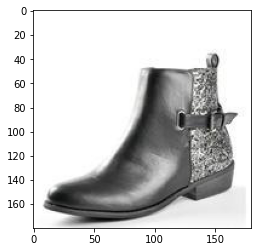

In [53]:
plt.imshow(mpimg.imread(filenames[4]))

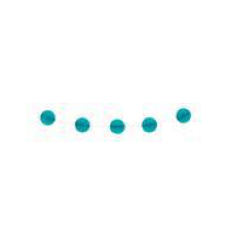

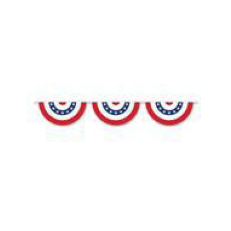

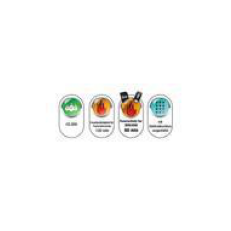

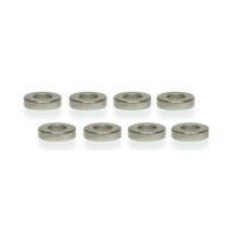

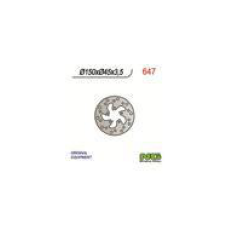

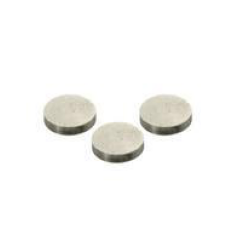

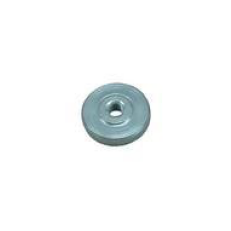

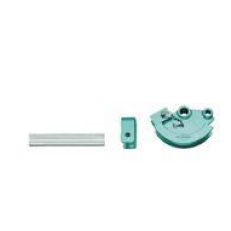

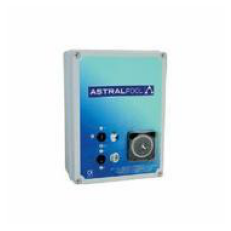

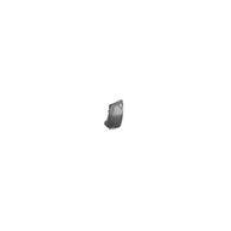

In [54]:
for i in range(indices.shape[1]):
  plt.imshow(mpimg.imread(filenames[indices[0][i]]))
  plt.axis('off')
  plt.show()


In [ ]:
# References

1. https://engineering.fb.com/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
2. https://medium.com/gsi-technology/integrating-textual-and-visual-information-into-a-powerful-visual-search-engine-c477486a18ff
3. https://github.com/gyang274/visual-search
4. https://www.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html